# Pore and Surface Diffusion Model (PSDM)

Originally developed by Michigan Technological University, coded in Python by USEPA

This can be used to model granular activated carbon (GAC) systems.

# 5.4 USEPA fouling approach

author: Jonathan Burkhardt @UCChEJBB,
         Levi Haupert
         
PFHpA data from article: 

*Modeling PFAS Removal Using Granular Activated Carbon for Full-Scale System Design*
         
edit: Mathieu Coghe, highlighted by *//Mathieu* (Ctrl+F)

In [1]:
## Import Required Packages
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import pylab as plt

import os
srt_dir = os.getcwd()

import PSDM
os.chdir(srt_dir)

In [2]:
fn = '5.4_Input_PFHpA.xlsx'

chem_data = PSDM.process_input_data(fn, sheet_name='Properties') 
k_data = pd.read_excel(fn, sheet_name='Kdata',index_col=0) # K & 1/n data

raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data',\
                                               column_sheet='columnSpecs'
                                              )

In [3]:
raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data_variable',\
                                               column_sheet='columnSpecs'
                                              )
## User can look at raw_data to see new variable influent, or 
## see "data_variable" sheet


Note: extra prints were added in PSDM.py *//Mathieu* (Ctrl+F)

PFHpA
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  PFHpA    1.0
dtype: float64
rk2:  PFHpA    0.0
dtype: float64
rk3:  PFHpA    0.0
dtype: float64
rk4:  PFHpA    0.0
dtype: float64
//Mathieu: k_mult_pd:  [1. 1. 1. 1. 1.]  ...
EBCT:  9.88  min
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    0.44
dtype: float64
b2:  PFHpA    0.36
dtype: float64
rk1:  PFHpA    0.514
dtype: float64
rk2:  PFHpA   -2.706000e-08
dtype: float64
rk3:  PFHpA    0.286
dtype: float64
rk4:  PFHpA   -0.000039
dtype: float64
//Mathieu: k_mult_pd:  [0.8        0.74181435 0.69540289 0.65837664 0.62883134]  ...


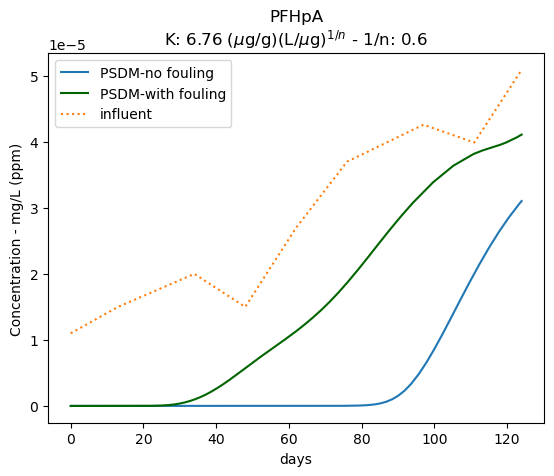

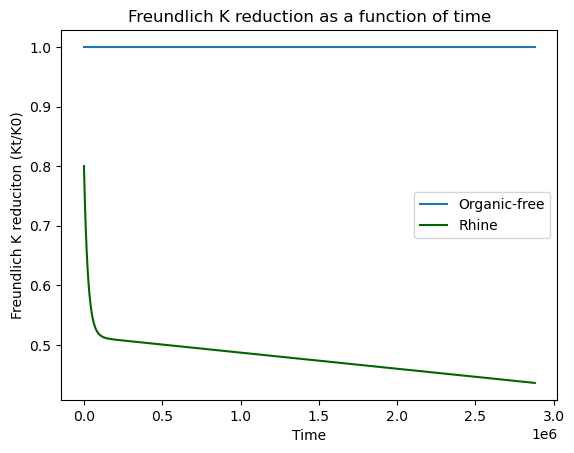

In [4]:
chem_type = 'PFAS'   #//Mathieu: according to article
water_type = 'Rhine' #//Mathieu: according to article
#note additional inputs in definition of column, below.

for comp in compounds:
    print(comp)
    
    # SETTING UP PSDM simulation column
    column = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    print('EBCT: ', round(column.ebct, 2), ' min') 
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    #only results is used in this example
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    column2 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   chem_type=chem_type,
                   water_type=water_type,
                   optimize=False
                   )
    
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    #only results is used in this example
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)
    
    ## plotting results 
    #units are converted from ug/L to mg/L 
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM-no fouling')
    plt.plot(results2.index, 
             results2.values/1000., 
             label='PSDM-with fouling',
             color='darkgreen')
    (raw_data[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example2.png', dpi=300)
    plt.show
    
    plt.figure()
    plt.plot(column.K_time, 
             column.K_mult_time,
             label='Organic-free')
    plt.plot(column2.K_time, 
             column2.K_mult_time,
             label='Rhine',
             color='darkgreen')    
    plt.legend()
    plt.title('Freundlich K reduction as a function of time')  # Title of the plot    
    plt.xlabel('Time')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis
    plt.grid(False)  # Enable grid
    plt.show()  # Display the plot    
    
    tab2 = 'model-'+comp
    
    with pd.ExcelWriter('Example_TCE_' + carbons[0] + '_example2.xlsx') as writer:
        results.to_excel(writer, sheet_name=tab2)



//Mathieu: The time axis for the K reduction graph has a special unit. After investigation of the code, it seemed that the time is plotted here for the max amount of days, which is 2000, and corresponds to 2 880 000 seconds. See later paragraph for adjustment of axis

In [5]:
len(column.K_mult_time)

500

In [6]:
len(column.K_time)

500

In [7]:
column.psdm_teller, column2.psdm_teller

(1, 1)

In [8]:
column.water_type, column2.water_type

('Organic Free', 'Rhine')

## K reduction time axis adjustment

//Mathieu: The **time axis** for the K reduction graph has a special unit. After investigation of the code, it seemed that the time is plotted here for the max amount of days, which is 2000, and corresponds to 2 880 000 seconds.

Below is the K reduction graph, but with the time axis corresponding to the right time of operation.

*With help of ChatGPT for troubleshooting*

length of K_mult array for 2000 days:  500  (see below for days)

[   0.            4.00801603    8.01603206   12.0240481    16.03206413
   20.04008016   24.04809619   28.05611222   32.06412826   36.07214429
   40.08016032   44.08817635   48.09619238   52.10420842   56.11222445
   60.12024048   64.12825651   68.13627255   72.14428858   76.15230461
   80.16032064   84.16833667   88.17635271   92.18436874   96.19238477
  100.2004008   104.20841683  108.21643287  112.2244489   116.23246493
  120.24048096  124.24849699  128.25651303  132.26452906  136.27254509
  140.28056112  144.28857715  148.29659319  152.30460922  156.31262525
  160.32064128  164.32865731  168.33667335  172.34468938  176.35270541
  180.36072144  184.36873747  188.37675351  192.38476954  196.39278557
  200.4008016   204.40881764  208.41683367  212.4248497   216.43286573
  220.44088176  224.4488978   228.45691383  232.46492986  236.47294589
  240.48096192  244.48897796  248.49699399  252.50501002  256.51302605
  260.52104

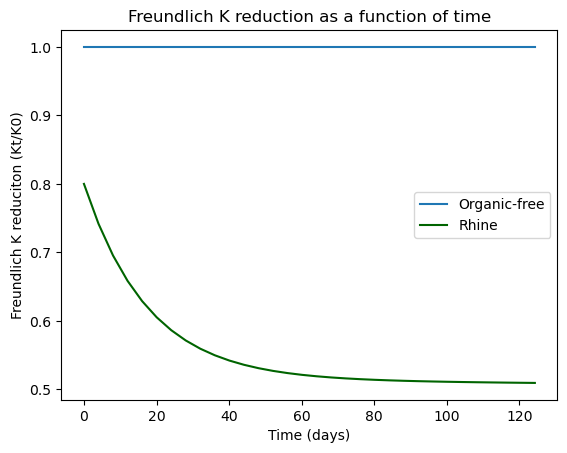

In [9]:
days_of_operation_column = 124

K_time = np.array(column.K_time)

K_time_days = K_time/(60*24)

print('length of K_mult array for 2000 days: ', len(K_time_days),' (see below for days)\n')
print(K_time_days,'\n')

index = np.argmax(K_time_days >= days_of_operation_column)
print('length of K_mult array for 124 days: ', index+1,' (see below for days)\n')

print(K_time_days[:index+1])
print('\n*Below is the K reduction graph with right time-axis*\n')

plt.figure()
plt.plot(K_time_days[:index+1], 
         column.K_mult_time[:index+1],
         label='Organic-free')
plt.plot(K_time_days[:index+1], 
         column2.K_mult_time[:index+1],
         label='Rhine',
         color='darkgreen')    
plt.legend()
plt.title('Freundlich K reduction as a function of time')  # Title of the plot    
plt.xlabel('Time (days)')  # Label for the x-axis
plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis
plt.grid(False)
plt.show()  # Display the plot    